# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the data
2. Sample nodes
3. Connect nodes
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data and provide a template for visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sampling import Sampler
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue

%matplotlib inline

In [2]:
import sys
!{sys.executable} -m pip install -Iv networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  1 location(s) to search for versions of networkx:
  * https://pypi.python.org/simple/networkx/
  Getting page https://pypi.python.org/simple/networkx/
  Looking up "https://pypi.python.org/simple/networkx/" in the cache
  Current age based on date: 8145
  Freshness lifetime from max-age: 600
  Freshness lifetime from request max-age: 600
  The cached response is "stale" with no etag, purging
  Starting new HTTPS connection (1): pypi.python.org
  "GET /simple/networkx/ HTTP/1.1" 200 11375
  Updating cache with response from "https://pypi.python.org/simple/networkx/"
  Caching b/c date exists and max-age > 0
  Analyzing links from page https://pypi.python.org/simple/networkx/
    Skipping link https://pypi.python.org/packages/01/01/7b7056bc70c410e17a530d5219f64cb2d8ca74569213c4ac90470c819566/networkx-1.7rc1-py2.6.egg#md5=9cf8e0e59ca11297c37dadd1dbd4484c (from https://pypi.python.org/simple/networkx/); unsupported archive format: .egg
    Skipping link https://pypi.python.org/packages/0

    Skipping link https://pypi.python.org/packages/a8/bf/63dfb0a2cda8ac078f5374dacce4c07a27f9e4724ec69b9919bb8d8b375a/networkx-1.5rc1-py2.6.egg#md5=83997b2aeb66a064fb280f2608d97528 (from https://pypi.python.org/simple/networkx/); unsupported archive format: .egg
    Skipping link https://pypi.python.org/packages/a8/d8/0a205cf758fd4ef6b1de344f46503b75ee61d2ba5f2ebe70bfcfd46f6763/networkx-0.99-py2.5.egg#md5=f404dddb292ec3d1c3e5d6297117093c (from https://pypi.python.org/simple/networkx/); unsupported archive format: .egg
    Skipping link https://pypi.python.org/packages/aa/c7/118c0d2c3b59a97fddcc93477e94dc4c85b8943c085b8eed71e78edfdb9d/networkx-1.6rc1-py2.6.egg#md5=37e616053be2b3f3575684cc116b95f1 (from https://pypi.python.org/simple/networkx/); unsupported archive format: .egg
    Skipping link https://pypi.python.org/packages/ab/4b/51850d412ddbfbe065d0f09bcd89878446ca216f3761033c3ab2f988f8ba/networkx-1.5rc1-py2.7.egg#md5=1eedae66b7f24e7d8bfb9cd2a6185f3d (from https://pypi.python.org/si

  1 location(s) to search for versions of decorator:
  * https://pypi.python.org/simple/decorator/
  Getting page https://pypi.python.org/simple/decorator/
  Looking up "https://pypi.python.org/simple/decorator/" in the cache
  Current age based on date: 8146
  Freshness lifetime from max-age: 600
  Freshness lifetime from request max-age: 600
  The cached response is "stale" with no etag, purging
  "GET /simple/decorator/ HTTP/1.1" 200 2490
  Updating cache with response from "https://pypi.python.org/simple/decorator/"
  Caching b/c date exists and max-age > 0
  Analyzing links from page https://pypi.python.org/simple/decorator/
    Found link https://pypi.python.org/packages/00/cc/dd79ea98a0ff5a01d714c37eddd99cd0a71557113f1511921d1ef9a083b8/decorator-4.0.11-py2.py3-none-any.whl#md5=0b3b4cad44b9ea580a7458c8f3e5e506 (from https://pypi.python.org/simple/decorator/), version: 4.0.11
    Found link https://pypi.python.org/packages/0c/6f/e81f4ef13afe85a89bb2e447b7d6635b5687f701f7d64b0a4873


Cleaning up...


In [3]:
nx.__version__ # Should be 2.1

'2.1'

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-305.  -435.    85.5    5.     5.    85.5]
 [-295.  -435.    85.5    5.     5.    85.5]
 [-285.  -435.    85.5    5.     5.    85.5]
 ..., 
 [ 435.   465.     8.     5.     5.     8. ]
 [ 445.   465.     8.     5.     5.     8. ]
 [ 455.   465.     8.     5.     5.     8. ]]


## Step 2 - Sample Points

We've implemented a custom sampling class using a k-d tree.

In [6]:
from sampling import Sampler

In [7]:
sampler = Sampler(data)
polygons = sampler._polygons

In [24]:
# Example: sampling 100 points and removing
# ones conflicting with obstacles.
nodes = sampler.sample(30)
print(len(nodes))

16


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through a polygon.

NOTE: You can use `LineString` to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths.

In [25]:
import numpy.linalg as LA
from sklearn.neighbors import KDTree

[[0 3 1]]


In [28]:
def can_connect(n1, n2):
    l = LineString([n1, n2])
    for p in polygons:
        if p.crosses(l) and p.height >= min(n1[2], n2[2]):
            return False
    return True

def create_graph(nodes, k):
    g = nx.Graph()
    tree = KDTree(nodes)
    for n1 in nodes:
        # for each node connect try to connect to k nearest nodes
        idxs = tree.query([n1], k, return_distance=False)[0]
        
        for idx in idxs:
            n2 = nodes[idx]
            if n2 == n1:
                continue
                
            if can_connect(n1, n2):
                g.add_edge(n1, n2, weight=1)
    return g

In [29]:
import time
t0 = time.time()
g = create_graph(nodes, 10)
print('graph took {0} seconds to build'.format(time.time()-t0))

graph took 1.4614942073822021 seconds to build


In [17]:
print("Number of edges", len(g.edges))

Number of edges 607


## Step 4 - Visualize Graph

In [18]:
from grid import create_grid

In [19]:
grid = create_grid(data, sampler._zmax, 1)

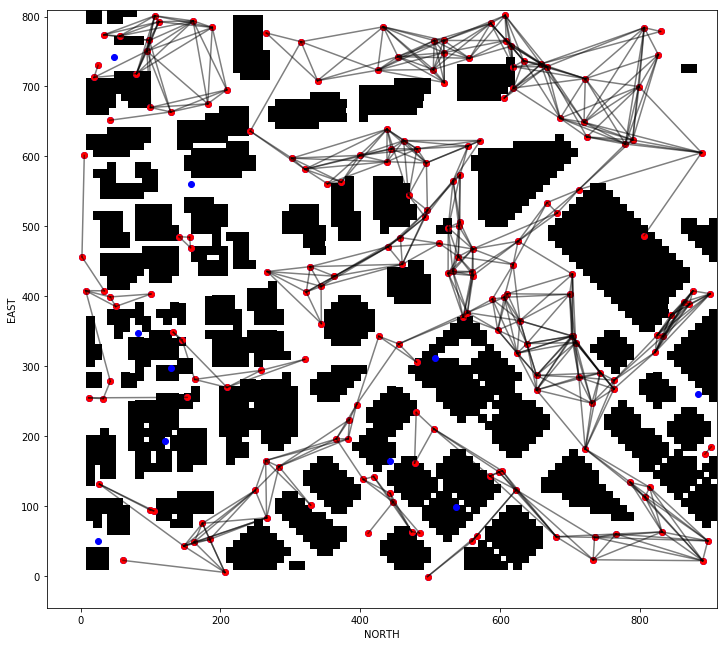

In [20]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# draw all nodes
for n1 in nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# draw connected nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [ ]:
def heuristic(n1, n2):
    # TODO: finish
    return LA.norm(np.array(n2) - np.array(n1))

## Step 6 - Complete A*

In [ ]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost

In [ ]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]

In [ ]:
path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

In [ ]:
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

## Step 7 - Visualize Path

In [ ]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()